#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [28]:
import wandb
import os
wandb.login(key=os.getenv("WANDB_API_KEY"))
wandb.init(project='distance_classification_project')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


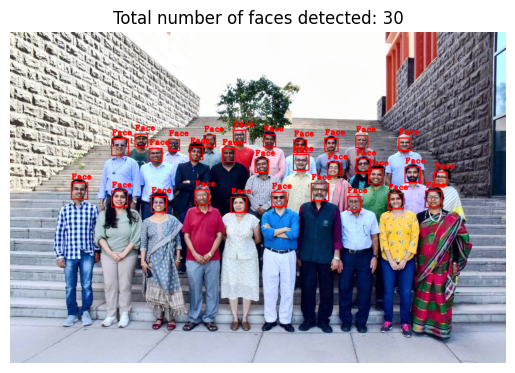

In [29]:
## Reading the image plaksha_Faculty.jpg
img = cv2.imread("images/Plaksha_Faculty.jpg")
  
## Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = "Face" ## The text you want to write
font = cv2.FONT_HERSHEY_COMPLEX_SMALL  ## Font type
font_scale = 1  ## Font scale factor
font_color = (0, 0, 255)  ## Text color in BGR format (here, it's red)
font_thickness = 2  ## Thickness of the text

  
# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(img, text, (x, y - 10), font, font_scale, font_color, font_thickness)
    
## Display the image and window title should be "Total number of face detected are #"  

wandb.log({"Number of detected faces": len(faces_rect)})

cv2.imwrite("output/Plaksha_Faculty_detected.jpg", img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Total number of faces detected: {}".format(len(faces_rect)))
plt.axis('off')
plt.show()

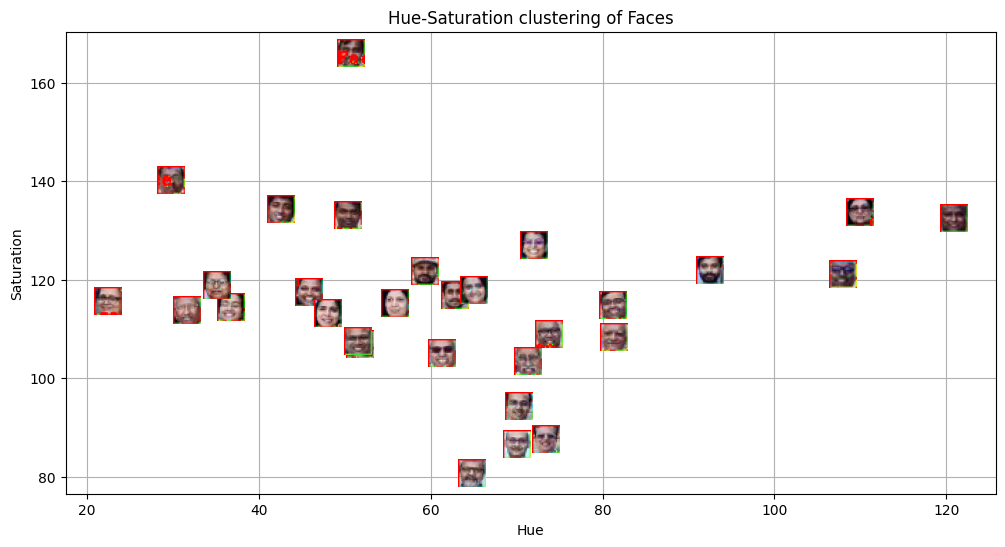

<Figure size 640x480 with 0 Axes>

In [30]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) ## call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init = "auto").fit(hue_saturation)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])
    
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title('Hue-Saturation clustering of Faces')
plt.grid()
plt.show()

wandb.log({"clustering of detected faces(Hue saturation)": wandb.Image(plt)})

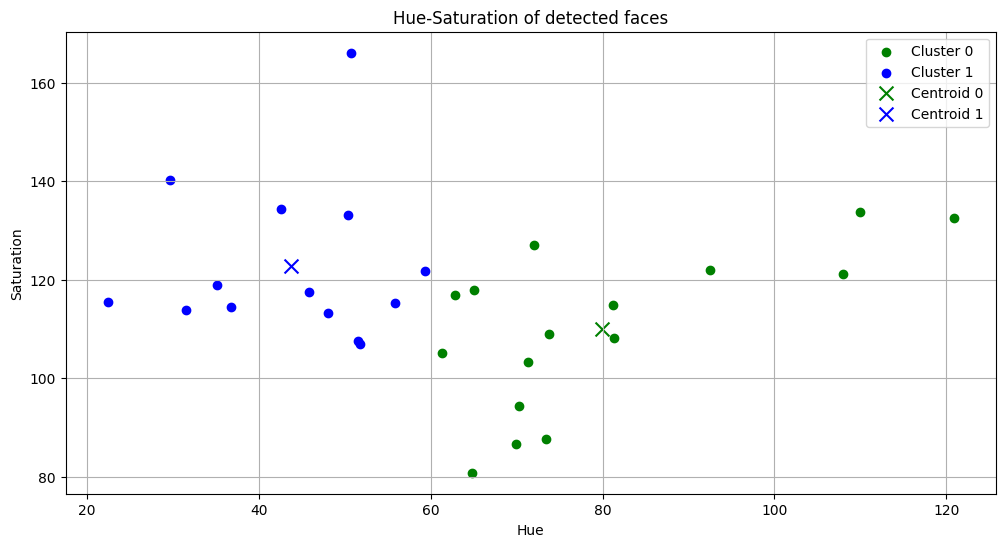

In [31]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')


cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')

# Calculate and plot centroids
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], color='green', marker='x', s=100, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], color='blue', marker='x', s=100, label='Centroid 1')

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Hue-Saturation of detected faces")
plt.legend()
plt.grid(True)
plt.show()
wandb.log({"Clustering of detected faces, legend-labels": wandb.Image(fig)})

In [32]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread("images/Dr_Shashi_Tharoor.jpg")
# Detect face in the template image after converting it to gray and store it in template_faces
grey_img = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
template_faces = face_cascade.detectMultiScale(grey_img, scaleFactor=1.05, minNeighbors=4, minSize=(50, 50), maxSize=(300, 300))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

##commenting them because imshow runs infinitely making a problem for github workflow
# cv2.imshow("Detected Faces", template_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


cv2.imwrite("output/detected_faces.jpg", template_img)
wandb.log({"Detected Faces": wandb.Image(template_img)})

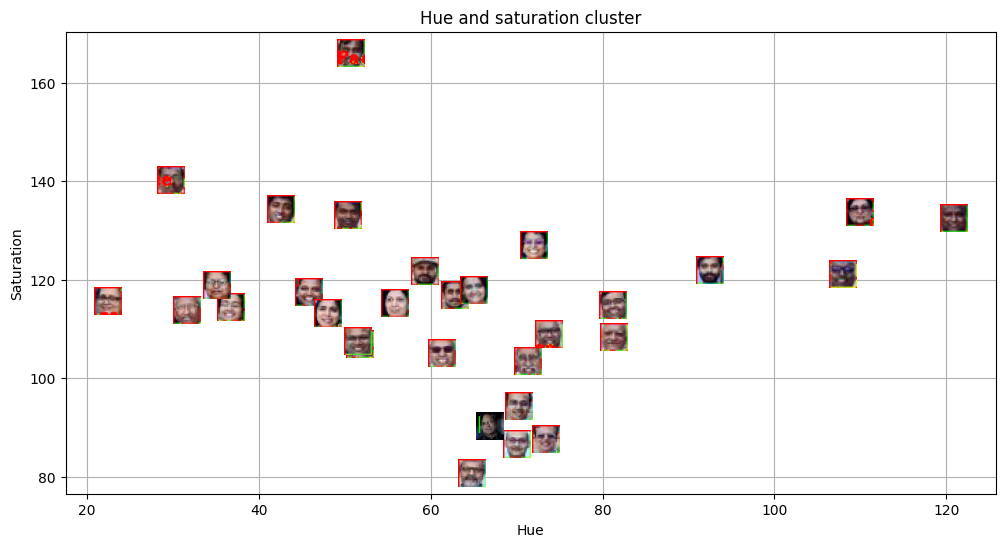

In [33]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Hue and saturation cluster")
plt.grid(True)
plt.show()
wandb.log({"Hue-saturation, clustering of image": wandb.Image(fig)})

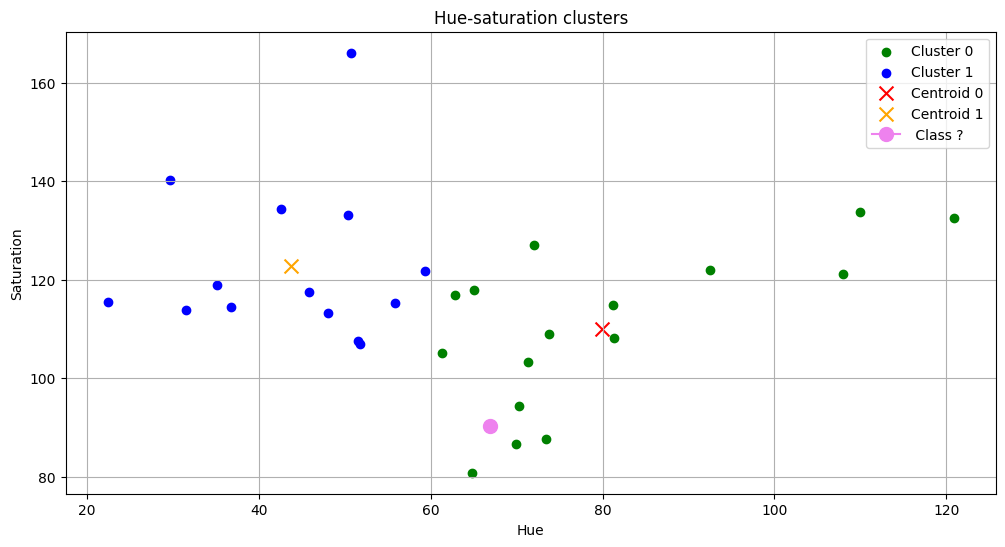

In [34]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='green', label='Cluster 0')

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='blue', label='Cluster 1')

# Calculate and plot centroids for both the clusters
centroid_0 = np.mean(cluster_0_points, axis=0)
centroid_1 = np.mean(cluster_1_points, axis=0)
plt.scatter(centroid_0[0], centroid_0[1], marker='x', c='red', s=100, label='Centroid 0') ## plot for centroid 0
plt.scatter(centroid_1[0], centroid_1[1], marker='x', c='orange', s=100, label='Centroid 1')  ## plot for centroid 1
plt.plot(template_hue, template_saturation, marker='o', c= 'violet',markersize= 10, label=' Class ?' )

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Hue-saturation clusters")
plt.legend()
plt.grid(True)
plt.show()
wandb.log({"Centroids and clusters": wandb.Image(fig)})                                         ## End of the lab 5 ##

## Report:
## Answer the following questions within your report:


#### 1. What are the common distance metrics used in distance-based classification algorithms? 
* Euclidean Distance 
* Manhattan Distance 
* Minkowski Distance 
* Mahalanobis Distance 

#### 2. What are some real-world applications of distance-based classification algorithms? 
- the real world application for distance-based classification could be
* face-recognition for security purposes
* medical-diagnosis, that can classify disease based on patient's similarity
* recommendation system for music apps and other applications

#### 3. Explain various distance metrics. 
* Euclidean Distance – it measures the straight line distance between 2 points, commonly used in clustering algorithms.
* Manhattan Distance – it computes the distance by summing absolute differences, its useful when movement is restricted to grid-like paths.
* Mahalanobis Distance – it is for the correlations in data, which makes it effective for detecting anomalies and classifying data with varying distributions.

#### 4. What is the role of cross validation in model performance? 
Cross-validation ensures reliable evaluation, it prevents overfitting, and it helps us select the optimal models by training and testing on different subsets of data, which improves generalization to unseen data.

#### 5. Explain variance and bias in terms of KNN? 
KNN has high variance and low bias, meaning it is sensitive to training data but does not assume a specific data distribution. A low K increases variance (overfitting), while a high K increases bias (underfitting), which requires careful selection for optimal performance.